In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm as tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
np.random.seed(12)
y = np.random.randint(0,4,300)
idx= []
for i in range(4):
    print(i,sum(y==i))
    idx.append(y==i)

0 80
1 72
2 75
3 73


In [3]:
x = np.zeros((300,2))

In [4]:
np.random.seed(12)
# covariance_matrix = np.eye(2)*0.01
# x[idx[0],:] = np.random.multivariate_normal(mean = [10,1],cov=covariance_matrix,size=sum(idx[0]))
# x[idx[1],:] = np.random.multivariate_normal(mean = [10,-1],cov=covariance_matrix,size=sum(idx[1]))
# x[idx[2],:] = np.random.multivariate_normal(mean = [15,0],cov=covariance_matrix,size=sum(idx[2]))
# x[idx[3],:] = np.random.multivariate_normal(mean = [-10,1],cov=np.eye(2)*0.5,size=sum(idx[3]))

x[idx[0],:] = np.random.uniform(low=[5,2],high=[6,4],size=(sum(idx[0]),2))

x[idx[1],:] = np.random.uniform(low=[5,-3],high=[6,-5],size=(sum(idx[1]),2))

x[idx[2],:] = np.random.uniform(low=[8,0],high=[9,-2],size=(sum(idx[2]),2))

x[idx[3],:] = np.random.uniform(low=[1,-1],high=[2,5],size=(sum(idx[3]),2))


In [5]:
x = (x-np.mean(x,axis=0,keepdims=True))/np.std(x,axis=0,keepdims=True)

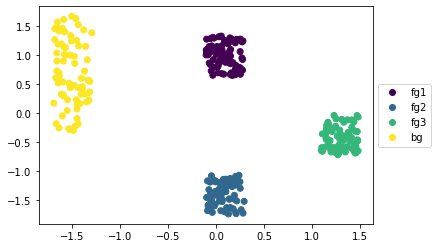

In [6]:
scatter = plt.scatter(x[:,0],x[:,1],c=y)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           handles=scatter.legend_elements()[0],labels=("fg1","fg2","fg3","bg"))

In [7]:
desired_num = 1500
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
m = 500
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,4)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,2)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|███████████████████████████████████████| 1500/1500 [00:18<00:00, 80.64it/s]


In [8]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [9]:
batch = 250
training_size = 500
msd1 = MosaicDataset(mosaic_list_of_images[0:training_size], mosaic_label[0:training_size] , fore_idx[0:training_size])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

msd2 = MosaicDataset(mosaic_list_of_images[training_size:], mosaic_label[training_size:] , fore_idx[training_size:])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [10]:
def my_cross_entropy(output,target,alpha,n_classes):
    if n_classes>2:
        criterion = nn.CrossEntropyLoss(reduce=False)
    else:
        criterion = nn.BCELoss(reduce=False)
    
    batch = output.size(0)
    patches = output.size(1)
    
    
    output = torch.reshape(output,(batch*patches,3))
    
    
    target = target.repeat_interleave(patches)
    
    loss = criterion(output,target)
    
    loss = torch.reshape(loss,(batch,patches))

    final_loss = torch.sum(torch.mul(loss,alpha),dim=1)

    final_loss = torch.mean(final_loss,dim=0)
    return final_loss

In [11]:
def save_analysis(trainloader,testloader,focus,classification,n_classes):
    focus.eval()
    classification.eval()
    fg_indexes = []
    alpha_argmax = []
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for data in trainloader:
            inputs, labels,foregrnd_index = data
            inputs = inputs.double()
            inputs = inputs.to(device)
            alphas,attnd_inputs= focus(inputs)
            outputs = classification(attnd_inputs)
            if n_classes > 2:
                _,predicted= torch.max(outputs,dim=1)
            else:
                predicted = (outputs.data[:,0]>0.5).type(torch.int64)
            
            true_labels.append(labels)
            predicted_labels.append(predicted.cpu().numpy())
            index = torch.argmax(alphas,dim=1)
            fg_indexes.append(foregrnd_index.numpy())
            alpha_argmax.append(index.cpu().numpy())
            #print(alphas[labels==0].shape,torch.max(alphas[labels==0],dim=1),"foreground",foregrnd_index[labels==0])
            #print(alphas[labels==1].shape,torch.max(alphas[labels==1],dim=1),"foreground",foregrnd_index[labels==1])
            #print(alphas[labels==2].shape,torch.max(alphas[labels==2],dim=1),"foreground",foregrnd_index[labels==2])
    fg_indexes = np.concatenate(fg_indexes,axis=0)
    alpha_argmax = np.concatenate(alpha_argmax,axis=0)
    true_labels = np.concatenate(true_labels,axis=0)
    predicted_labels = np.concatenate(predicted_labels,axis=0)

    
    ftpt = np.sum(np.logical_and(alpha_argmax == fg_indexes, predicted_labels == true_labels))
    ffpt = np.sum(np.logical_and(alpha_argmax != fg_indexes, predicted_labels == true_labels))
    ftpf = np.sum(np.logical_and(alpha_argmax == fg_indexes, predicted_labels != true_labels))
    ffpf = np.sum(np.logical_and(alpha_argmax != fg_indexes, predicted_labels != true_labels))
    trn_analysis = [ftpt,ffpt,ftpf,ffpf]
    
    fg_indexes = []
    alpha_argmax = []
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for data in testloader:
            inputs, labels,foregrnd_index = data
            inputs = inputs.double()
            inputs = inputs.to(device)
            alphas,attnd_inputs= focus(inputs)
            outputs = classification(attnd_inputs)
            if len(torch.unique(labels)) > 2:
                _,predicted= torch.max(outputs,dim=1)
            else:
                predicted = (outputs.data[:,0]>0.5).type(torch.int64)
                
            true_labels.append(labels)
            predicted_labels.append(predicted.cpu().numpy())
            index = torch.argmax(alphas,dim=1)
            fg_indexes.append(foregrnd_index.numpy())
            alpha_argmax.append(index.cpu().numpy())
    fg_indexes = np.concatenate(fg_indexes,axis=0)
    alpha_argmax = np.concatenate(alpha_argmax,axis=0)
    true_labels = np.concatenate(true_labels,axis=0)
    predicted_labels = np.concatenate(predicted_labels,axis=0)    
    ftpt = np.sum(np.logical_and(alpha_argmax == fg_indexes, predicted_labels == true_labels))
    ffpt = np.sum(np.logical_and(alpha_argmax != fg_indexes, predicted_labels == true_labels))
    ftpf = np.sum(np.logical_and(alpha_argmax == fg_indexes, predicted_labels != true_labels))
    ffpf = np.sum(np.logical_and(alpha_argmax != fg_indexes, predicted_labels != true_labels))
    tst_analysis = [ftpt,ffpt,ftpf,ffpf]
    
    
    return trn_analysis,tst_analysis

# soft attention

In [12]:
class Focus(nn.Module):
    def __init__(self,input_dims,attention,bias_=False,bn_=False):
        super(Focus, self).__init__()
        self.input_dims = input_dims 
        self.attention = attention
        self.bias_ = bias_
        self.fc1 = nn.Linear(self.input_dims,1, bias=self.bias_)
        self.bn_ = bn_
        if self.bn_:
            self.bn = nn.BatchNorm1d(input_dims)
        
    def forward_soft_Attention(self,z):
        batch = z.size(0)
        patches = z.size(1)
        z = z.view(batch,patches,self.input_dims)
        alp1,ft1 = self.helper(z)
        alpha = F.softmax(alp1,dim=1)
        y = torch.sum(alpha*ft1,dim=1)
        
        if self.bn_:
            y = self.bn(y)
        
        alpha =alpha[:,:,0]
        return alpha,y   # return  alpha values,attended data
    def forward_hard_Attention(self,z):
        batch = z.size(0)
        patches = z.size(1)
        z = z.view(batch,patches,2*1)
        alp1,ft1 = self.helper(z)

        alpha = F.softmax(alp1,dim=1)
        
        if self.training:
            alpha =alpha[:,:,0]
            y = ft1 
            return alpha,y
        else:
            index = torch.argmax(alpha,dim=1)
            #print(index)
            hard_alpha = torch.nn.functional.one_hot(index[:,0], patches)
            y = torch.sum(hard_alpha[:,:,None]*ft1,dim=1)
            alpha = alpha[:,:,0]
            return alpha,y
        
    def forward(self,z): 
        if self.attention == "hard":
            alpha,y = self.forward_hard_Attention(z)
            return alpha,y
        elif self.attention == "soft":
            alpha,y = self.forward_soft_Attention(z)
            return alpha,y
        else:
            print("not correct Attention type")
            return None

    def helper(self, x):
        x1 = x
        x = self.fc1(x)
        return x,x1

In [13]:
class Classification(nn.Module):
    def __init__(self,input_dims,output_dims):
        super(Classification, self).__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims 
        self.fc1 = nn.Linear(self.input_dims, self.output_dims)
    def forward(self, x):
        x = self.fc1(x)
        if self.output_dims ==1:
            x = torch.sigmoid(x)
        return x

In [14]:
def initialize_zeros_weights(m):
    if isinstance(m,nn.Linear):
        nn.init.zeros_(m.weight.data)
        if m.bias is not None:
            nn.init.zeros_(m.bias.data)

In [15]:
def train_attention_models(trainloader,focus_module,classification_module,
                           n_classes,nos_epochs,attention,learning_rate=0.01):
    
    
    if n_classes > 2:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCELoss()
    optimizer_classify = optim.SGD(classification_module.parameters(), lr=learning_rate)#,  momentum=0.09)
    optimizer_focus = optim.SGD(focus_module.parameters(), lr=learning_rate)# , momentum=0.09)
    loss_list=[]
    for epoch in range(nos_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_loss = []
        focus_module.train()
        classification_module.train()
        for i, data in  enumerate(trainloader):
            inputs , labels , fore_idx = data
            batch = inputs.size(0)
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.double()
            # zero the parameter gradients
            optimizer_focus.zero_grad()
            optimizer_classify.zero_grad()
            alphas, avg_images = focus_module(inputs)
            outputs = classification_module(avg_images)
            #print(outputs.shape)
            
            # predicted values
            if n_classes > 2:
                _,predicted= torch.max(outputs,dim=1)
            else:
                predicted = (outputs.data[:,0]>0.5).type(torch.int64)
            
            # calculate loss
            if attention == "soft":
                loss = criterion(outputs,labels)
            if attention == "hard":
                loss = my_cross_entropy(outputs,labels,alphas,n_classes)
            loss.backward()
            optimizer_focus.step()
            optimizer_classify.step()
            epoch_loss.append(loss.item())
        print('[%d] loss: %.3f' %(epoch + 1, np.mean(epoch_loss)))
        loss_list.append(np.mean(epoch_loss))
        if(np.mean(epoch_loss) <= 0.01):
            break
    print('Finished Training')
    return focus_module,classification_module,loss_list 


In [16]:
focus_net = Focus(input_dims = 2,attention="soft",bias_=False,bn_=False).double()
focus_net = focus_net.to(device)

classify = Classification(input_dims=2,output_dims=3).double()
classify = classify.to(device)

focus_net.apply(initialize_zeros_weights)
classify.apply(initialize_zeros_weights)
# parameters
for params in focus_net.parameters():
    print(params)
for params in classify.parameters():
    print(params)

Parameter containing:
tensor([[0., 0.]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0., 0., 0.], dtype=torch.float64, requires_grad=True)


In [17]:
save_analysis(train_loader,test_loader,focus_net,classify,3) # ftpt ffpt ftpf ffpf

([0, 164, 0, 336], [1, 321, 1, 677])

In [18]:
focus_net,classify,loss_list = train_attention_models(train_loader,focus_net,classify,
                           learning_rate=0.5,n_classes=3,nos_epochs=10000,attention="soft")

[1] loss: 1.101
[2] loss: 1.100
[3] loss: 1.100
[4] loss: 1.100
[5] loss: 1.100
[6] loss: 1.100
[7] loss: 1.105
[8] loss: 1.101
[9] loss: 1.099
[10] loss: 1.104
[11] loss: 1.099
[12] loss: 1.100
[13] loss: 1.099
[14] loss: 1.099
[15] loss: 1.099
[16] loss: 1.099
[17] loss: 1.104
[18] loss: 1.100
[19] loss: 1.101
[20] loss: 1.099
[21] loss: 1.099
[22] loss: 1.100
[23] loss: 1.099
[24] loss: 1.099
[25] loss: 1.100
[26] loss: 1.100
[27] loss: 1.099
[28] loss: 1.099
[29] loss: 1.099
[30] loss: 1.101
[31] loss: 1.099
[32] loss: 1.099
[33] loss: 1.099
[34] loss: 1.099
[35] loss: 1.102
[36] loss: 1.100
[37] loss: 1.100
[38] loss: 1.100
[39] loss: 1.099
[40] loss: 1.102
[41] loss: 1.101
[42] loss: 1.103
[43] loss: 1.100
[44] loss: 1.099
[45] loss: 1.099
[46] loss: 1.102
[47] loss: 1.100
[48] loss: 1.102
[49] loss: 1.104
[50] loss: 1.101
[51] loss: 1.099
[52] loss: 1.104
[53] loss: 1.099
[54] loss: 1.103
[55] loss: 1.103
[56] loss: 1.103
[57] loss: 1.100
[58] loss: 1.099
[59] loss: 1.100
[60] l

[468] loss: 1.063
[469] loss: 1.049
[470] loss: 1.023
[471] loss: 0.965
[472] loss: 0.836
[473] loss: 0.648
[474] loss: 0.503
[475] loss: 0.408
[476] loss: 0.340
[477] loss: 0.288
[478] loss: 0.249
[479] loss: 0.217
[480] loss: 0.193
[481] loss: 0.173
[482] loss: 0.157
[483] loss: 0.143
[484] loss: 0.132
[485] loss: 0.122
[486] loss: 0.114
[487] loss: 0.107
[488] loss: 0.101
[489] loss: 0.095
[490] loss: 0.090
[491] loss: 0.086
[492] loss: 0.081
[493] loss: 0.078
[494] loss: 0.074
[495] loss: 0.071
[496] loss: 0.069
[497] loss: 0.066
[498] loss: 0.064
[499] loss: 0.061
[500] loss: 0.059
[501] loss: 0.057
[502] loss: 0.055
[503] loss: 0.054
[504] loss: 0.052
[505] loss: 0.051
[506] loss: 0.049
[507] loss: 0.048
[508] loss: 0.047
[509] loss: 0.045
[510] loss: 0.044
[511] loss: 0.043
[512] loss: 0.042
[513] loss: 0.041
[514] loss: 0.040
[515] loss: 0.039
[516] loss: 0.038
[517] loss: 0.038
[518] loss: 0.037
[519] loss: 0.036
[520] loss: 0.035
[521] loss: 0.035
[522] loss: 0.034
[523] loss

In [19]:
save_analysis(train_loader,test_loader,focus_net,classify,3)

([500, 0, 0, 0], [1000, 0, 0, 0])

In [20]:
for params in focus_net.parameters():
    print(params)
for params in classify.parameters():
    print(params)

Parameter containing:
tensor([[ 3.7737, -1.5962]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[-2.6763,  2.4238],
        [-1.1106, -3.4000],
        [ 3.7868,  0.9763]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([ 0.4304, -0.4892,  0.0588], dtype=torch.float64, requires_grad=True)


In [21]:
attended_data = []
labels_ = []
focus_net.eval()
classify.eval()
with torch.no_grad():
    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        batch = inputs.size(0)
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.double()
        labels_.append(labels.numpy())
        # zero the parameter gradients
        alphas, avg_images = focus_net(inputs)
        max_values,_ = torch.max(alphas[labels==0],dim=1)
        non_max_values,_ = torch.topk(alphas[labels==0],k=99,largest=False) 
        
        max_values_1,_ = torch.max(alphas[labels==1],dim=1)
        non_max_values_1,_ = torch.topk(alphas[labels==1],k=99,largest=False) 
        
        max_values_2,_ = torch.max(alphas[labels==2],dim=1)
        non_max_values_2,_ = torch.topk(alphas[labels==2],k=99,largest=False) 
        
        #print(alphas[np.arange(fore_idx.shape[0]),torch.argmax(alphas,dim=1)])
        attended_data.append(avg_images.numpy())
attended_data = np.concatenate(attended_data,axis=0)
labels_ = np.concatenate(labels_,axis=0)

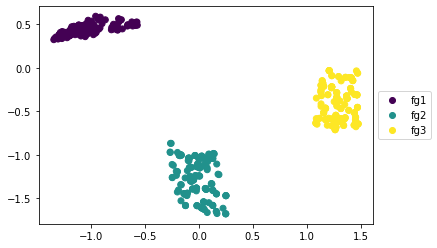

In [22]:
scatter = plt.scatter(attended_data[:,0],attended_data[:,1],c=labels_)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           handles=scatter.legend_elements()[0],labels=("fg1","fg2","fg3"))

In [23]:
# scatter = plt.scatter(x[:,0],x[:,1],c=y)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
#            handles=scatter.legend_elements()[0],labels=("fg1","fg2","fg3","bg"))

In [24]:
# print(max_values)
# sorted_values,_ = torch.sort(non_max_values,descending=True)
# sorted_values[0,0:20]

In [25]:
# print(max_values_1)
# sorted_values,_ = torch.sort(non_max_values_1,descending=True)
# sorted_values[0,0:20]

In [26]:
# print(max_values_2)
# sorted_values,_ = torch.sort(non_max_values_2,descending=True)
# sorted_values[0,0:20]

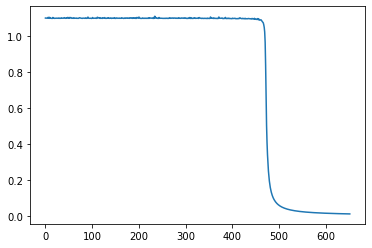

In [27]:
plt.plot(loss_list)

In [28]:
# attended_data

# hard attention

In [29]:
focus_net = Focus(input_dims = 2,attention="hard").double()
focus_net = focus_net.to(device)

classify = Classification(input_dims=2,output_dims=3).double()
classify = classify.to(device)

focus_net.apply(initialize_zeros_weights)
classify.apply(initialize_zeros_weights)
# parameters
for params in focus_net.parameters():
    print(params)
for params in classify.parameters():
    print(params)

Parameter containing:
tensor([[0., 0.]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0., 0., 0.], dtype=torch.float64, requires_grad=True)


In [30]:
focus_net,classify,loss_list = train_attention_models(train_loader,focus_net,classify,
                           learning_rate=0.5,n_classes=3,nos_epochs=10000,attention="hard")

[1] loss: 1.101
[2] loss: 1.101
[3] loss: 1.102
[4] loss: 1.100
[5] loss: 1.105


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[6] loss: 1.105
[7] loss: 1.106
[8] loss: 1.100
[9] loss: 1.099
[10] loss: 1.099
[11] loss: 1.100
[12] loss: 1.100
[13] loss: 1.102
[14] loss: 1.102
[15] loss: 1.099
[16] loss: 1.099
[17] loss: 1.099
[18] loss: 1.105
[19] loss: 1.099
[20] loss: 1.099
[21] loss: 1.099
[22] loss: 1.100
[23] loss: 1.099
[24] loss: 1.100
[25] loss: 1.100
[26] loss: 1.100
[27] loss: 1.103
[28] loss: 1.099
[29] loss: 1.100
[30] loss: 1.103
[31] loss: 1.100
[32] loss: 1.100
[33] loss: 1.103
[34] loss: 1.102
[35] loss: 1.102
[36] loss: 1.102
[37] loss: 1.100
[38] loss: 1.099
[39] loss: 1.100
[40] loss: 1.099
[41] loss: 1.099
[42] loss: 1.099
[43] loss: 1.100
[44] loss: 1.101
[45] loss: 1.099
[46] loss: 1.100
[47] loss: 1.100
[48] loss: 1.101
[49] loss: 1.100
[50] loss: 1.100
[51] loss: 1.099
[52] loss: 1.100
[53] loss: 1.099
[54] loss: 1.102
[55] loss: 1.100
[56] loss: 1.099
[57] loss: 1.099
[58] loss: 1.100
[59] loss: 1.099
[60] loss: 1.100
[61] loss: 1.103
[62] loss: 1.101
[63] loss: 1.100
[64] loss: 1.099
[

[470] loss: 1.100
[471] loss: 1.099
[472] loss: 1.104
[473] loss: 1.101
[474] loss: 1.100
[475] loss: 1.099
[476] loss: 1.099
[477] loss: 1.099
[478] loss: 1.100
[479] loss: 1.100
[480] loss: 1.103
[481] loss: 1.099
[482] loss: 1.100
[483] loss: 1.100
[484] loss: 1.099
[485] loss: 1.101
[486] loss: 1.099
[487] loss: 1.100
[488] loss: 1.103
[489] loss: 1.103
[490] loss: 1.099
[491] loss: 1.100
[492] loss: 1.099
[493] loss: 1.100
[494] loss: 1.101
[495] loss: 1.099
[496] loss: 1.099
[497] loss: 1.101
[498] loss: 1.102
[499] loss: 1.101
[500] loss: 1.099
[501] loss: 1.099
[502] loss: 1.100
[503] loss: 1.100
[504] loss: 1.101
[505] loss: 1.101
[506] loss: 1.101
[507] loss: 1.103
[508] loss: 1.107
[509] loss: 1.102
[510] loss: 1.101
[511] loss: 1.103
[512] loss: 1.099
[513] loss: 1.101
[514] loss: 1.105
[515] loss: 1.099
[516] loss: 1.099
[517] loss: 1.103
[518] loss: 1.105
[519] loss: 1.100
[520] loss: 1.099
[521] loss: 1.099
[522] loss: 1.099
[523] loss: 1.108
[524] loss: 1.100
[525] loss

[931] loss: 1.099
[932] loss: 1.098
[933] loss: 1.100
[934] loss: 1.097
[935] loss: 1.097
[936] loss: 1.097
[937] loss: 1.096
[938] loss: 1.097
[939] loss: 1.099
[940] loss: 1.097
[941] loss: 1.097
[942] loss: 1.096
[943] loss: 1.098
[944] loss: 1.096
[945] loss: 1.096
[946] loss: 1.097
[947] loss: 1.096
[948] loss: 1.097
[949] loss: 1.096
[950] loss: 1.097
[951] loss: 1.095
[952] loss: 1.095
[953] loss: 1.095
[954] loss: 1.095
[955] loss: 1.096
[956] loss: 1.097
[957] loss: 1.096
[958] loss: 1.095
[959] loss: 1.093
[960] loss: 1.092
[961] loss: 1.091
[962] loss: 1.092
[963] loss: 1.091
[964] loss: 1.088
[965] loss: 1.087
[966] loss: 1.086
[967] loss: 1.083
[968] loss: 1.085
[969] loss: 1.077
[970] loss: 1.068
[971] loss: 1.061
[972] loss: 1.040
[973] loss: 1.008
[974] loss: 0.954
[975] loss: 0.875
[976] loss: 0.791
[977] loss: 0.711
[978] loss: 0.640
[979] loss: 0.573
[980] loss: 0.512
[981] loss: 0.457
[982] loss: 0.410
[983] loss: 0.371
[984] loss: 0.337
[985] loss: 0.309
[986] loss

In [31]:
save_analysis(train_loader,test_loader,focus_net,classify,3) # ftpt ffpt ftpf ffpf

([500, 0, 0, 0], [1000, 0, 0, 0])

In [32]:
attended_data = []
labels_ = []
focus_net.eval()
classify.eval()
with torch.no_grad():
    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        batch = inputs.size(0)
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.double()
        labels_.append(labels.numpy())
        # zero the parameter gradients
        alphas, avg_images = focus_net(inputs)
        max_values,_ = torch.max(alphas[labels==0],dim=1)
        non_max_values,_ = torch.topk(alphas[labels==0],k=99,largest=False)
        #print(alphas[np.arange(alphas.shape[0]),torch.argmax(alphas,dim=1)],torch.argmax(alphas,dim=1),fore_idx)
        outputs = torch.sigmoid(classify(avg_images))
        attended_data.append(avg_images.numpy())
#         loss = my_cross_entropy(outputs[:,0], labels.double(),alphas) 

In [33]:
attended_data = np.concatenate(attended_data,axis=0)
# labels_ = np.concatenate(labels_,axis=0)

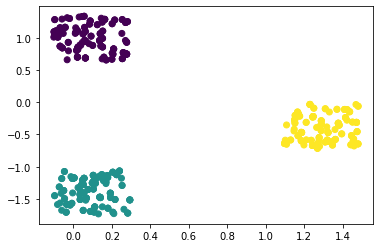

In [34]:
plt.scatter(attended_data[:,0],attended_data[:,1],c=labels_)

In [35]:
print(max_values)
sorted_values,_ = torch.sort(non_max_values,descending=True)
sorted_values[:,0:10]

tensor([0.0828, 0.0886, 0.4164, 0.0704, 0.0433, 0.3544, 0.2822, 0.2873, 0.3491,
        0.1737, 0.1884, 0.0179, 0.1368, 0.1779, 0.0593, 0.2062, 0.2718, 0.6049,
        0.3558, 0.4807, 0.3391, 0.0683, 0.0596, 0.5281, 0.0510, 0.2119, 0.0462,
        0.1181, 0.4990, 0.1771, 0.0635, 0.2746, 0.1808, 0.5244, 0.0167, 0.5111,
        0.0436, 0.1287, 0.0431, 0.4861, 0.1062, 0.6075, 0.0864, 0.2596, 0.3021,
        0.1580, 0.1246, 0.0390, 0.1516, 0.5138, 0.2911, 0.0883, 0.1403, 0.5456,
        0.1507, 0.0665, 0.0566, 0.0311, 0.0642, 0.0293, 0.1035, 0.0973, 0.0296,
        0.0725, 0.2092, 0.0443, 0.4433, 0.1916, 0.5775, 0.0973, 0.3269, 0.1757,
        0.1020, 0.3510, 0.1549, 0.0411, 0.0689, 0.0525, 0.3101, 0.0565, 0.2703,
        0.1462, 0.1340, 0.1033, 0.1235, 0.0718, 0.1881, 0.0670, 0.1346, 0.0489,
        0.2060], dtype=torch.float64)


tensor([[1.6350e-05, 1.6350e-05, 1.6350e-05, 1.4531e-05, 1.4531e-05, 1.4531e-05,
         1.4531e-05, 1.4531e-05, 1.4531e-05, 1.4531e-05],
        [1.3965e-05, 1.3333e-05, 1.3333e-05, 1.3333e-05, 1.3333e-05, 1.3333e-05,
         1.3333e-05, 1.3333e-05, 9.1781e-06, 9.1781e-06],
        [8.2007e-06, 8.2007e-06, 8.2007e-06, 7.8294e-06, 7.8294e-06, 7.8294e-06,
         7.8294e-06, 7.8294e-06, 7.8294e-06, 7.8294e-06],
        [1.7688e-05, 1.7688e-05, 1.7688e-05, 1.7688e-05, 1.7688e-05, 1.7688e-05,
         1.5831e-05, 1.5831e-05, 1.5831e-05, 1.5831e-05],
        [1.6234e-05, 1.6234e-05, 1.5499e-05, 1.5499e-05, 1.5499e-05, 1.5499e-05,
         1.5499e-05, 1.5499e-05, 1.5499e-05, 1.5499e-05],
        [1.2271e-05, 1.2271e-05, 1.0906e-05, 1.0906e-05, 1.0906e-05, 1.0906e-05,
         1.0906e-05, 1.0906e-05, 1.0906e-05, 1.0412e-05],
        [1.2997e-05, 1.1551e-05, 1.1551e-05, 1.1551e-05, 1.1551e-05, 1.1551e-05,
         1.1551e-05, 1.1551e-05, 1.1551e-05, 1.1551e-05],
        [1.4456e-05, 1.2938

In [36]:
for params in focus_net.parameters():
    print(params)
for params in classify.parameters():
    print(params)

Parameter containing:
tensor([[ 4.8512, -4.2030]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[-3.3804,  3.1352],
        [-1.0876, -3.7078],
        [ 4.4680,  0.5726]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([ 2.0368, -0.9607, -1.0761], dtype=torch.float64, requires_grad=True)


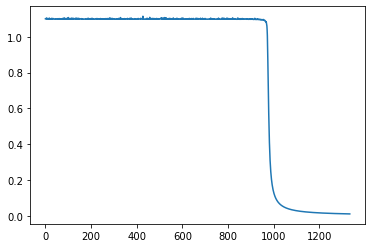

In [37]:
plt.plot(loss_list)

# train a max-margin classifier

In [38]:
fg_bg_labels = np.ones(y.shape)
fg_bg_labels[np.where(y==3)] = 0

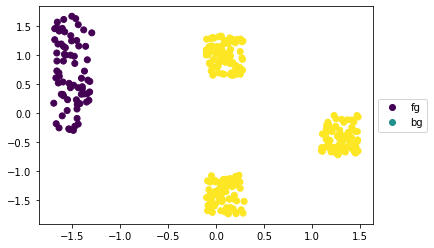

In [39]:
plt.scatter(x[:,0],x[:,1],c=fg_bg_labels)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           handles=scatter.legend_elements()[0],labels=("fg","bg"))

In [40]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0,fit_intercept=True)
clf.fit(x,fg_bg_labels)

LinearSVC(random_state=0)

In [41]:
sum(clf.predict(x) == fg_bg_labels)

300

In [42]:
clf.coef_,clf.intercept_

(array([[ 1.49467446, -0.00920422]]), array([1.06334517]))

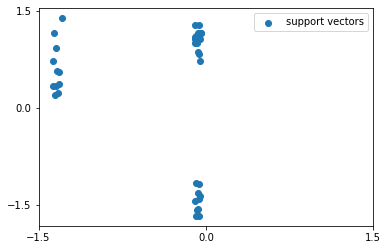

In [43]:
decision_function = clf.decision_function(x)
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors = x[support_vector_indices]
plt.scatter(support_vectors[:,0],support_vectors[:,1],label="support vectors")
plt.xticks([-1.5,0.0,1.5])
plt.yticks([-1.5,0.0,1.5])
plt.legend()


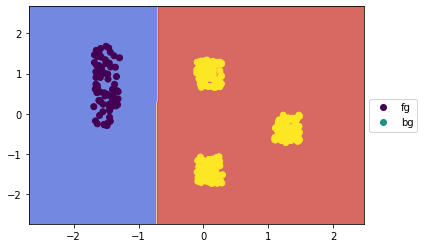

In [44]:
# create a mesh to plot in
h = 0.02
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(x[:,0],x[:,1],c=fg_bg_labels)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           handles=scatter.legend_elements()[0],labels=("fg","bg"))


In [45]:
beta = torch.tensor([0,0.01,0.02,0.04,0.08,0.16,0.32,0.50,0.64,1,1.28,2.56,5.12])
directions = torch.tensor([[1,0],[1/np.sqrt(2),1/np.sqrt(2)],[0,1],
              [-1/np.sqrt(2),1/np.sqrt(2)],[-1,0],[-1/np.sqrt(2),-1/np.sqrt(2)],[0,-1],[1/np.sqrt(2),-1/np.sqrt(2)]])

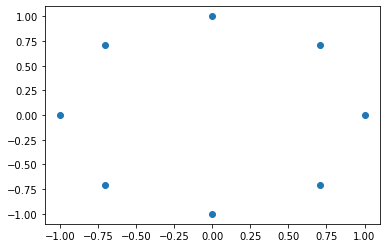

In [46]:
plt.scatter(directions[:,0],directions[:,1])

In [47]:
def generate_attended_data(trainloader,focus,focus_direction=None):
    attended_data = []
    attended_labels = []
    for i, data in  enumerate(trainloader):
        inputs , labels , fore_idx = data
        batch = inputs.size(0)
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.double()
        if focus_direction is None:
            alphas, avg_data = focus(inputs)
        else:
            z = inputs
            batch = z.size(0)
            patches = z.size(1)
            dims = z.size(2)
            z = z.view(batch,patches,dims)
            alp1,ft1 = focus.helper(z)
            alp2,ft2 = focus_direction.helper(z)
            alp3 = alp1 + alp2
            alpha = F.softmax(alp3,dim=1)
            y = torch.sum(alpha*ft1,dim=1)
            alpha =alpha[:,:,0]
            avg_data = y
            
            
        attended_data.append(avg_data)
        attended_labels.append(labels)
    attended_data = torch.cat(attended_data,dim=0)
    attended_labels = torch.cat(attended_labels,dim=0)
    #plt.figure()
    #plt.scatter(attended_data[:,0],attended_data[:,1],c=attended_labels)
    return attended_data,attended_labels
        
    

In [48]:
def calculate_loss(data,labels,net,criterion):
    net.eval()
    with torch.no_grad():
        outputs = net(data)
        loss = criterion(outputs,labels)
    return loss.item()
        
        
        

In [49]:
def train_classification_model(attended_data,attended_labels, classify_model,n_classes,test_list,learning_rate=0.01):
    nos_epochs = 300
    if n_classes > 2:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCELoss()
    optimizer_classify = optim.SGD(classify_model.parameters(), lr=learning_rate)#,  momentum=0.09)
    loss_list=[]
    test_loss_list = []
    #print("ddd",attended_data,attended_labels)
    #print("sss",test_list[0])
    
    with torch.no_grad():
        test_loss_epoch  = [] 
        epoch_loss = []
        
        # for train data at epoch zero
        outputs = classify_model(attended_data)
        loss = criterion(outputs,attended_labels)
        epoch_loss.append(loss.item())
        # for test data at epoch zero
        test_loss_epoch  = [] 
        for data in test_list:
            test_inputs,test_labels = data
            classify_model.eval()
            test_outputs = classify_model(test_inputs)
            test_loss = criterion(test_outputs,test_labels)
            test_loss_epoch.append(test_loss.item())
        test_loss_list.append(test_loss_epoch)
    loss_list.append(np.mean(epoch_loss))
        
    
    
    for epoch in range(nos_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_loss = []
        test_loss_epoch  = [] 
        classify_model.train()
        # zero the parameter gradients
        optimizer_classify.zero_grad()
        outputs = classify_model(attended_data)
        #print(outputs.shape)
        # predicted values
        if n_classes > 2:
            _,predicted= torch.max(outputs,dim=1)
        else:
            predicted = (outputs.data[:,0]>0.5).type(torch.int64)
        loss = criterion(outputs,attended_labels)
        loss.backward()
        optimizer_classify.step()
        
        loss_ = calculate_loss(attended_data,attended_labels,classify_model,criterion)
        epoch_loss.append(loss_)
        print('[%d] loss: %.3f' %(epoch + 1, np.mean(epoch_loss)))
        loss_list.append(np.mean(epoch_loss))
        # loss for test list, At every epoch for every direction perform forward pass and calculate loss
        for data in test_list:
            test_inputs,test_labels = data
            test_loss = calculate_loss(test_inputs,test_labels,classify_model,criterion)
            test_loss_epoch.append(test_loss)
        test_loss_list.append(test_loss_epoch)    
        if(np.mean(epoch_loss) <= 0.01):
            break    
    print('Finished Training')
    print(len(loss_list),len(test_loss_list))
    return classify_model,loss_list,test_loss_list
    
    

In [50]:
weight = torch.tensor([[1.49467446, -0.00920422]],dtype=torch.float64)
weight = weight/torch.linalg.norm(weight)
print(torch.linalg.norm(weight))
loss_beta = []
test_loss_beta = []
for beta_ in beta:
    focus_net = Focus(input_dims = 2,attention="soft").double()
    focus_net = focus_net.to(device)
    focus_net.fc1.weight.data = beta_*weight
    focus_net.fc1.weight.requires_grad = False
    

    
    classify = Classification(input_dims=2,output_dims=3).double()
    classify.apply(initialize_zeros_weights)
    classify = classify.to(device)
    

    
    print("Parameters")
    
    for params in focus_net.named_parameters():
        print(params)
    
    # attended data for focus model 
    f_attended_data,f_labels = generate_attended_data(train_loader,focus_net)
    
    # test attended data for focus model with 8 directions
    test_attended_data = []
    test_attended_data.append([f_attended_data,f_labels])
    
    for u in directions:
        focus_net_direction = Focus(input_dims = 2,attention="soft").double()
        focus_net_direction = focus_net_direction.to(device)
        focus_net_direction.fc1.weight.data = 0.01*u[None,:]
        focus_net_direction.fc1.weight.requires_grad = False
        d_attended_data,d_labels = generate_attended_data(train_loader,focus_net,focus_net_direction)

        test_attended_data.append([d_attended_data,d_labels])

        
        
    
    _,loss_list,test_loss_list = train_classification_model(f_attended_data,f_labels,classify,
                                             n_classes=3,test_list=test_attended_data,learning_rate=0.5)
    
    test_loss_list = np.array(test_loss_list)
    
    loss_beta.append(loss_list)
    test_loss_beta.append(test_loss_list)
        
    

    

tensor(1.0000, dtype=torch.float64)
Parameters
('fc1.weight', Parameter containing:
tensor([[0., -0.]], dtype=torch.float64))
[1] loss: 1.099
[2] loss: 1.099
[3] loss: 1.099
[4] loss: 1.099
[5] loss: 1.099
[6] loss: 1.099
[7] loss: 1.099
[8] loss: 1.099
[9] loss: 1.099
[10] loss: 1.099
[11] loss: 1.099
[12] loss: 1.099
[13] loss: 1.099
[14] loss: 1.099
[15] loss: 1.099
[16] loss: 1.099
[17] loss: 1.099
[18] loss: 1.099
[19] loss: 1.099
[20] loss: 1.099
[21] loss: 1.099
[22] loss: 1.099
[23] loss: 1.099
[24] loss: 1.099
[25] loss: 1.099
[26] loss: 1.099
[27] loss: 1.099
[28] loss: 1.099
[29] loss: 1.099
[30] loss: 1.099
[31] loss: 1.099
[32] loss: 1.099
[33] loss: 1.099
[34] loss: 1.099
[35] loss: 1.099
[36] loss: 1.099
[37] loss: 1.099
[38] loss: 1.099
[39] loss: 1.099
[40] loss: 1.099
[41] loss: 1.099
[42] loss: 1.099
[43] loss: 1.099
[44] loss: 1.099
[45] loss: 1.099
[46] loss: 1.099
[47] loss: 1.099
[48] loss: 1.099
[49] loss: 1.099
[50] loss: 1.099
[51] loss: 1.099
[52] loss: 1.099

[213] loss: 1.098
[214] loss: 1.098
[215] loss: 1.098
[216] loss: 1.098
[217] loss: 1.098
[218] loss: 1.098
[219] loss: 1.098
[220] loss: 1.098
[221] loss: 1.098
[222] loss: 1.098
[223] loss: 1.098
[224] loss: 1.098
[225] loss: 1.098
[226] loss: 1.098
[227] loss: 1.098
[228] loss: 1.098
[229] loss: 1.098
[230] loss: 1.098
[231] loss: 1.098
[232] loss: 1.098
[233] loss: 1.098
[234] loss: 1.098
[235] loss: 1.098
[236] loss: 1.098
[237] loss: 1.098
[238] loss: 1.098
[239] loss: 1.098
[240] loss: 1.098
[241] loss: 1.098
[242] loss: 1.098
[243] loss: 1.098
[244] loss: 1.098
[245] loss: 1.098
[246] loss: 1.098
[247] loss: 1.098
[248] loss: 1.098
[249] loss: 1.098
[250] loss: 1.098
[251] loss: 1.098
[252] loss: 1.098
[253] loss: 1.098
[254] loss: 1.098
[255] loss: 1.098
[256] loss: 1.098
[257] loss: 1.098
[258] loss: 1.098
[259] loss: 1.098
[260] loss: 1.098
[261] loss: 1.098
[262] loss: 1.098
[263] loss: 1.098
[264] loss: 1.098
[265] loss: 1.098
[266] loss: 1.098
[267] loss: 1.098
[268] loss

[105] loss: 1.098
[106] loss: 1.098
[107] loss: 1.098
[108] loss: 1.098
[109] loss: 1.098
[110] loss: 1.098
[111] loss: 1.098
[112] loss: 1.098
[113] loss: 1.098
[114] loss: 1.098
[115] loss: 1.098
[116] loss: 1.098
[117] loss: 1.098
[118] loss: 1.098
[119] loss: 1.098
[120] loss: 1.098
[121] loss: 1.098
[122] loss: 1.098
[123] loss: 1.098
[124] loss: 1.098
[125] loss: 1.098
[126] loss: 1.098
[127] loss: 1.098
[128] loss: 1.098
[129] loss: 1.098
[130] loss: 1.098
[131] loss: 1.098
[132] loss: 1.098
[133] loss: 1.098
[134] loss: 1.098
[135] loss: 1.098
[136] loss: 1.098
[137] loss: 1.098
[138] loss: 1.098
[139] loss: 1.098
[140] loss: 1.098
[141] loss: 1.098
[142] loss: 1.098
[143] loss: 1.098
[144] loss: 1.098
[145] loss: 1.098
[146] loss: 1.098
[147] loss: 1.098
[148] loss: 1.098
[149] loss: 1.098
[150] loss: 1.098
[151] loss: 1.098
[152] loss: 1.098
[153] loss: 1.098
[154] loss: 1.098
[155] loss: 1.098
[156] loss: 1.098
[157] loss: 1.098
[158] loss: 1.098
[159] loss: 1.098
[160] loss

[263] loss: 1.098
[264] loss: 1.098
[265] loss: 1.098
[266] loss: 1.098
[267] loss: 1.098
[268] loss: 1.098
[269] loss: 1.098
[270] loss: 1.098
[271] loss: 1.098
[272] loss: 1.098
[273] loss: 1.098
[274] loss: 1.098
[275] loss: 1.098
[276] loss: 1.098
[277] loss: 1.098
[278] loss: 1.098
[279] loss: 1.098
[280] loss: 1.098
[281] loss: 1.098
[282] loss: 1.098
[283] loss: 1.098
[284] loss: 1.098
[285] loss: 1.098
[286] loss: 1.098
[287] loss: 1.098
[288] loss: 1.098
[289] loss: 1.098
[290] loss: 1.098
[291] loss: 1.098
[292] loss: 1.098
[293] loss: 1.098
[294] loss: 1.098
[295] loss: 1.098
[296] loss: 1.098
[297] loss: 1.098
[298] loss: 1.098
[299] loss: 1.098
[300] loss: 1.098
Finished Training
301 301
Parameters
('fc1.weight', Parameter containing:
tensor([[ 0.1600, -0.0010]], dtype=torch.float64))
[1] loss: 1.099
[2] loss: 1.099
[3] loss: 1.099
[4] loss: 1.099
[5] loss: 1.099
[6] loss: 1.099
[7] loss: 1.099
[8] loss: 1.099
[9] loss: 1.099
[10] loss: 1.099
[11] loss: 1.099
[12] loss: 1.

[162] loss: 1.098
[163] loss: 1.098
[164] loss: 1.098
[165] loss: 1.098
[166] loss: 1.098
[167] loss: 1.098
[168] loss: 1.098
[169] loss: 1.098
[170] loss: 1.098
[171] loss: 1.098
[172] loss: 1.098
[173] loss: 1.098
[174] loss: 1.098
[175] loss: 1.098
[176] loss: 1.098
[177] loss: 1.098
[178] loss: 1.098
[179] loss: 1.098
[180] loss: 1.098
[181] loss: 1.098
[182] loss: 1.098
[183] loss: 1.098
[184] loss: 1.098
[185] loss: 1.098
[186] loss: 1.098
[187] loss: 1.098
[188] loss: 1.098
[189] loss: 1.098
[190] loss: 1.098
[191] loss: 1.098
[192] loss: 1.098
[193] loss: 1.098
[194] loss: 1.098
[195] loss: 1.098
[196] loss: 1.098
[197] loss: 1.098
[198] loss: 1.098
[199] loss: 1.098
[200] loss: 1.098
[201] loss: 1.098
[202] loss: 1.098
[203] loss: 1.098
[204] loss: 1.098
[205] loss: 1.098
[206] loss: 1.098
[207] loss: 1.098
[208] loss: 1.098
[209] loss: 1.098
[210] loss: 1.098
[211] loss: 1.098
[212] loss: 1.098
[213] loss: 1.098
[214] loss: 1.098
[215] loss: 1.098
[216] loss: 1.098
[217] loss

[67] loss: 1.098
[68] loss: 1.098
[69] loss: 1.098
[70] loss: 1.098
[71] loss: 1.098
[72] loss: 1.098
[73] loss: 1.098
[74] loss: 1.098
[75] loss: 1.098
[76] loss: 1.098
[77] loss: 1.098
[78] loss: 1.098
[79] loss: 1.098
[80] loss: 1.098
[81] loss: 1.098
[82] loss: 1.098
[83] loss: 1.098
[84] loss: 1.098
[85] loss: 1.098
[86] loss: 1.098
[87] loss: 1.098
[88] loss: 1.098
[89] loss: 1.098
[90] loss: 1.098
[91] loss: 1.098
[92] loss: 1.098
[93] loss: 1.098
[94] loss: 1.098
[95] loss: 1.097
[96] loss: 1.097
[97] loss: 1.097
[98] loss: 1.097
[99] loss: 1.097
[100] loss: 1.097
[101] loss: 1.097
[102] loss: 1.097
[103] loss: 1.097
[104] loss: 1.097
[105] loss: 1.097
[106] loss: 1.097
[107] loss: 1.097
[108] loss: 1.097
[109] loss: 1.097
[110] loss: 1.097
[111] loss: 1.097
[112] loss: 1.097
[113] loss: 1.097
[114] loss: 1.097
[115] loss: 1.097
[116] loss: 1.097
[117] loss: 1.097
[118] loss: 1.097
[119] loss: 1.097
[120] loss: 1.097
[121] loss: 1.097
[122] loss: 1.097
[123] loss: 1.097
[124] l

[287] loss: 1.075
[288] loss: 1.075
[289] loss: 1.075
[290] loss: 1.075
[291] loss: 1.075
[292] loss: 1.075
[293] loss: 1.075
[294] loss: 1.075
[295] loss: 1.075
[296] loss: 1.074
[297] loss: 1.074
[298] loss: 1.074
[299] loss: 1.074
[300] loss: 1.074
Finished Training
301 301
Parameters
('fc1.weight', Parameter containing:
tensor([[ 1.2800, -0.0079]], dtype=torch.float64))
[1] loss: 1.098
[2] loss: 1.097
[3] loss: 1.097
[4] loss: 1.096
[5] loss: 1.096
[6] loss: 1.096
[7] loss: 1.095
[8] loss: 1.095
[9] loss: 1.094
[10] loss: 1.094
[11] loss: 1.094
[12] loss: 1.093
[13] loss: 1.093
[14] loss: 1.092
[15] loss: 1.092
[16] loss: 1.092
[17] loss: 1.091
[18] loss: 1.091
[19] loss: 1.090
[20] loss: 1.090
[21] loss: 1.090
[22] loss: 1.089
[23] loss: 1.089
[24] loss: 1.089
[25] loss: 1.088
[26] loss: 1.088
[27] loss: 1.087
[28] loss: 1.087
[29] loss: 1.087
[30] loss: 1.086
[31] loss: 1.086
[32] loss: 1.085
[33] loss: 1.085
[34] loss: 1.085
[35] loss: 1.084
[36] loss: 1.084
[37] loss: 1.083
[38

[178] loss: 0.288
[179] loss: 0.287
[180] loss: 0.286
[181] loss: 0.285
[182] loss: 0.285
[183] loss: 0.284
[184] loss: 0.283
[185] loss: 0.283
[186] loss: 0.282
[187] loss: 0.281
[188] loss: 0.281
[189] loss: 0.280
[190] loss: 0.279
[191] loss: 0.279
[192] loss: 0.278
[193] loss: 0.277
[194] loss: 0.277
[195] loss: 0.276
[196] loss: 0.275
[197] loss: 0.275
[198] loss: 0.274
[199] loss: 0.273
[200] loss: 0.273
[201] loss: 0.272
[202] loss: 0.271
[203] loss: 0.271
[204] loss: 0.270
[205] loss: 0.269
[206] loss: 0.269
[207] loss: 0.268
[208] loss: 0.268
[209] loss: 0.267
[210] loss: 0.266
[211] loss: 0.266
[212] loss: 0.265
[213] loss: 0.264
[214] loss: 0.264
[215] loss: 0.263
[216] loss: 0.263
[217] loss: 0.262
[218] loss: 0.261
[219] loss: 0.261
[220] loss: 0.260
[221] loss: 0.260
[222] loss: 0.259
[223] loss: 0.259
[224] loss: 0.258
[225] loss: 0.257
[226] loss: 0.257
[227] loss: 0.256
[228] loss: 0.256
[229] loss: 0.255
[230] loss: 0.255
[231] loss: 0.254
[232] loss: 0.253
[233] loss

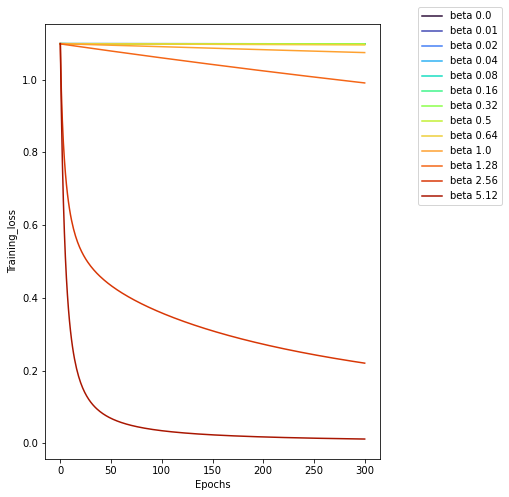

In [51]:
cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(6,8))
for i,j in enumerate(loss_beta):
    plt.plot(j,label ="beta "+str(np.around(beta[i].item(),3)),color = cm(i*20))

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig("cin_train_loss_4.png",bbox_inches='tight')

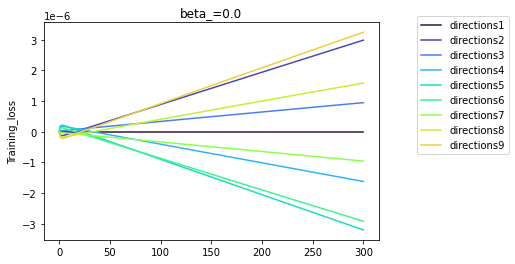

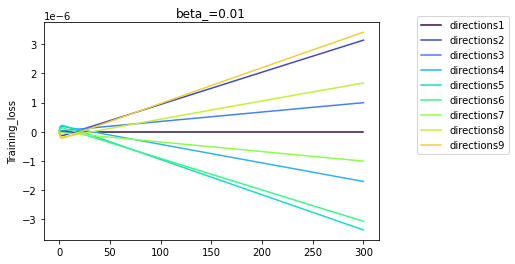

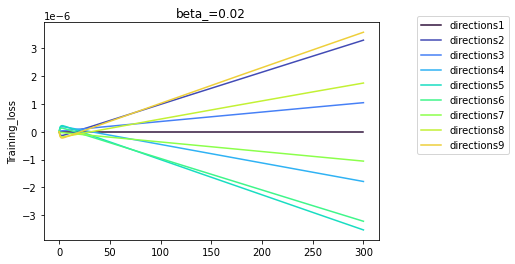

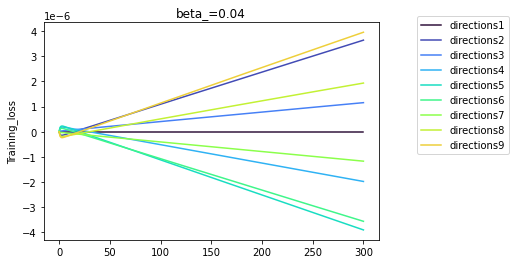

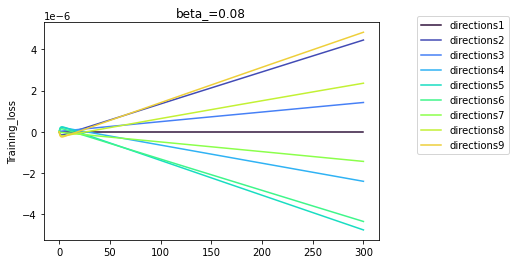

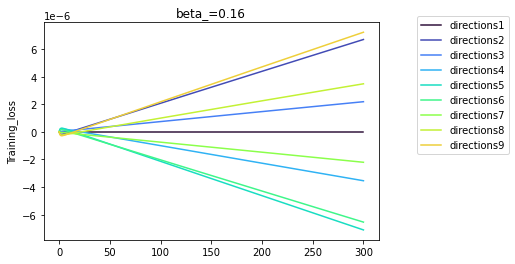

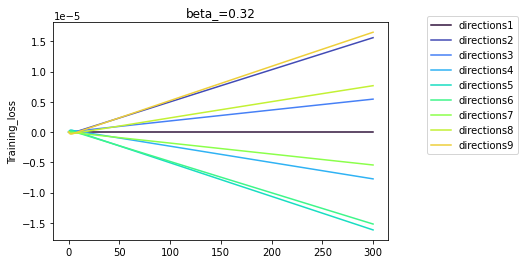

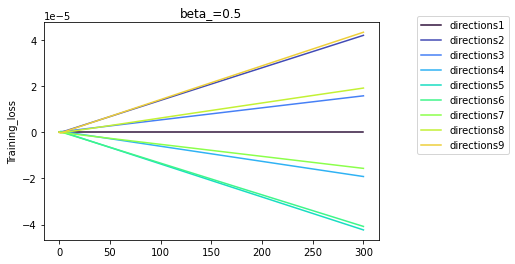

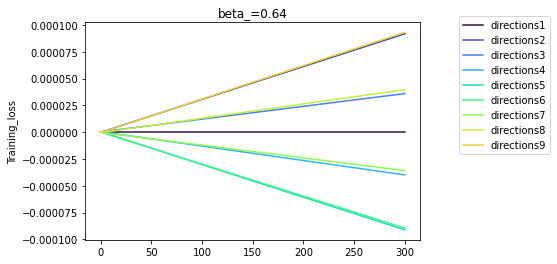

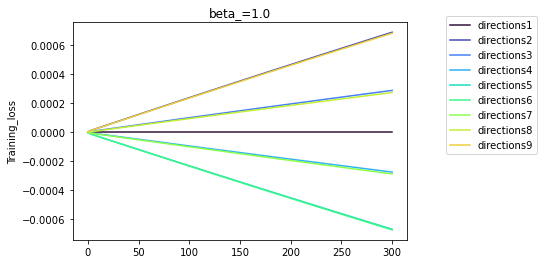

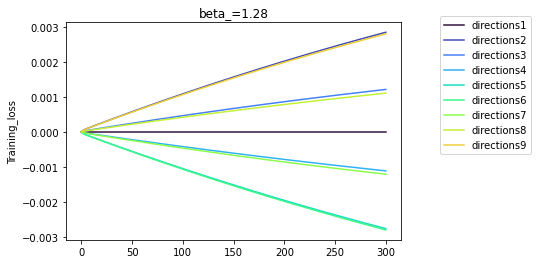

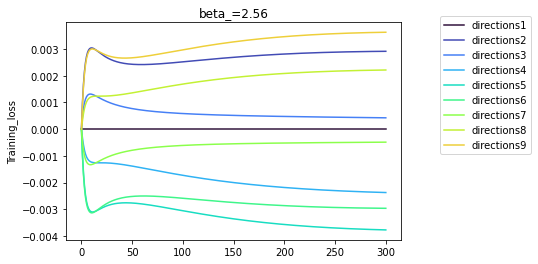

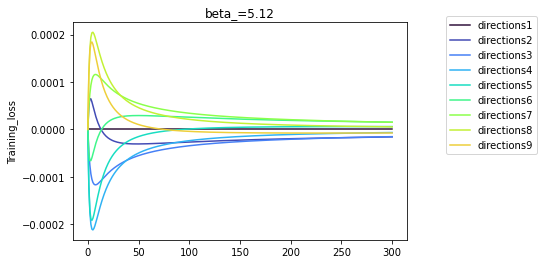

In [52]:
for j in range(len(beta)):
    plt.figure()
    for i in range(len(directions)+1):
        temp = np.array(loss_beta[j]) - test_loss_beta[j][:,i]
        plt.plot(temp,label ="directions"+str(i+1),color = cm(i*20))
        plt.ylabel("Training_loss")
        plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.title("beta_="+str(np.around(beta[j].item(),3)))
        plt.savefig("cin_train_loss_4_loss_beta_"+str(j)+".png",bbox_inches='tight')

In [53]:
# test_loss_beta

In [54]:
# test_loss_beta[0][:,1]

In [55]:
def hard_attention_generate_attended_data(trainloader,focus,focus_direction=None):
    mosaic_data = [] 
    attended_labels = []
    alpha_data = []
    
    for i, data in  enumerate(trainloader):
        inputs , labels , fore_idx = data
        batch = inputs.size(0)
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.double()
        if focus_direction is None:
            alpha, avg_data = focus(inputs)
        else:
            z = inputs
            batch = z.size(0)
            patches = z.size(1)
            dims = z.size(2)
            z = z.view(batch,patches,dims)
            alp1,ft1 = focus.helper(z)
            alp2,ft2 = focus_direction.helper(z)
            alp3 = alp1 + alp2
            alpha = F.softmax(alp3,dim=1)[:,:,0]
        mosaic_data.append(inputs)
        attended_labels.append(labels)
        alpha_data.append(alpha)
        
    mosaic_data = torch.cat(mosaic_data,dim=0)
    attended_labels = torch.cat(attended_labels,dim=0)
    alpha_data = torch.cat(alpha_data,dim=0)
    return mosaic_data,attended_labels,alpha_data

In [56]:
def hard_attention_calculate_loss(data,labels,alphas,net,criterion,train_mode=True):
    if train_mode:
        net.train()
        outputs = net(data)
        batch = outputs.size(0)
        patches = outputs.size(1)
        classes = outputs.size(2)
        
        outputs = torch.reshape(outputs,(batch*patches,classes))
        labels = labels.repeat_interleave(patches)
        loss = criterion(outputs,labels)
        loss = torch.reshape(loss,(batch,patches))
        loss = torch.mul(alphas,loss)
        loss = torch.sum(loss,dim=1)
        loss = torch.mean(loss)
        return loss
    else:  
        net.eval()
        with torch.no_grad():
            outputs = net(data)
            batch = outputs.size(0)
            patches = outputs.size(1)
            classes = outputs.size(2)
            outputs = torch.reshape(outputs,(batch*patches,classes))
            labels = labels.repeat_interleave(patches)
            loss = criterion(outputs,labels)
            loss = torch.reshape(loss,(batch,patches))
            loss = torch.mul(alphas,loss)
            loss = torch.sum(loss,dim=1)
            loss = torch.mean(loss)
            return loss.item()

In [57]:
def train_hard_attention_classification_model(mosaic_data,mosaic_labels,alphas,classify_model,
                               n_classes,test_list,learning_rate=0.01):
    nos_epochs = 300
    if n_classes > 2:
        criterion = nn.CrossEntropyLoss(reduction="none")
    else:
        criterion = nn.BCELoss(reduction="none")
    optimizer_classify = optim.SGD(classify_model.parameters(), lr=learning_rate)#,  momentum=0.09)
    loss_list=[]
    test_loss_list = []
    #print("ddd",attended_data,attended_labels)
    #print("sss",test_list[0])
    with torch.no_grad():
        test_loss_epoch  = [] 
        epoch_loss = []
        
        # for train data at epoch zero
        loss = hard_attention_calculate_loss(mosaic_data,mosaic_labels,
                                             alphas,classify_model,criterion,train_mode=False)
        
        epoch_loss.append(loss)
        # for test data at epoch zero
        test_loss_epoch  = [] 
        for data in test_list:
            test_mosaic_data,test_mosaic_labels,test_alphas = data
            #print(test_mosaic_data.shape,test_mosaic_labels.shape,test_alphas.shape)
            
            test_loss = hard_attention_calculate_loss(test_mosaic_data,test_mosaic_labels,
                                                      test_alphas,classify_model,criterion,train_mode=False)
            test_loss_epoch.append(test_loss)
        test_loss_list.append(test_loss_epoch)
    loss_list.append(np.mean(epoch_loss))
        
    
    
    for epoch in range(nos_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_loss = []
        test_loss_epoch  = [] 
        classify_model.train()
        # zero the parameter gradients
        optimizer_classify.zero_grad()
        #outputs = classify_model(mosaic_data)
        #print(outputs.shape)
        # predicted values
        if n_classes > 2:
            _,predicted= torch.max(outputs,dim=1)
        else:
            predicted = (outputs.data[:,0]>0.5).type(torch.int64)
        loss = hard_attention_calculate_loss(mosaic_data,mosaic_labels,
                                             alphas,classify_model,criterion,train_mode=True)
        loss.backward()
        optimizer_classify.step()
        loss_ = hard_attention_calculate_loss(mosaic_data,mosaic_labels,
                                              alphas,classify_model,criterion,train_mode=False)
        epoch_loss.append(loss_)
        print('[%d] loss: %.3f' %(epoch + 1, np.mean(epoch_loss)))
        loss_list.append(np.mean(epoch_loss))
        # loss for test list, At every epoch for every direction perform forward pass and calculate loss
        for data in test_list:
            test_mosaic_data,test_mosaic_labels,test_alphas = data
            test_loss = hard_attention_calculate_loss(test_mosaic_data,test_mosaic_labels,test_alphas,
                                       classify_model,criterion,train_mode=False)
            test_loss_epoch.append(test_loss)
        test_loss_list.append(test_loss_epoch)    
        if(np.mean(epoch_loss) <= 0.01):
            break
    print('Finished Training')
    print(len(loss_list),len(test_loss_list))
    return classify_model,loss_list,test_loss_list

In [58]:
weight = torch.tensor([[1.49467446, -0.00920422]],dtype=torch.float64)
weight = weight/torch.linalg.norm(weight)
print(torch.linalg.norm(weight))
loss_beta = []
test_loss_beta = []
for beta_ in beta:
    focus_net = Focus(input_dims = 2,attention="hard").double()
    focus_net = focus_net.to(device)
    focus_net.fc1.weight.data = beta_*weight
    focus_net.fc1.weight.requires_grad = False
    

    
    classify = Classification(input_dims=2,output_dims=3).double()
    classify.apply(initialize_zeros_weights)
    classify = classify.to(device)
    

    
    print("Parameters")
    
    for params in focus_net.named_parameters():
        print(params)
    
    # attended data for focus model 
    f_mosaic_data,f_mosaic_labels,f_alphas =  hard_attention_generate_attended_data(train_loader,focus_net)
    
    
    # test attended data for focus model with 8 directions
    test_attended_data = []
    test_attended_data.append([f_mosaic_data,f_mosaic_labels,f_alphas])
    
    for u in directions:
        focus_net_direction = Focus(input_dims = 2,attention="hard").double()
        focus_net_direction = focus_net_direction.to(device)
        focus_net_direction.fc1.weight.data = 0.01*u[None,:]
        focus_net_direction.fc1.weight.requires_grad = False
        d_mosaic_data,d_mosaic_labels,d_alphas =  hard_attention_generate_attended_data(train_loader,
                                                                                        focus_net,
                                                                                        focus_net_direction)

        test_attended_data.append([d_mosaic_data,d_mosaic_labels,d_alphas ])

        
        
    
    _,loss_list,test_loss_list = train_hard_attention_classification_model(f_mosaic_data,f_mosaic_labels,
                                                                          f_alphas,classify,n_classes=3,
                                                                          test_list=test_attended_data,
                                                                          learning_rate=0.5)
    
    test_loss_list = np.array(test_loss_list)
    
    loss_beta.append(loss_list)
    test_loss_beta.append(test_loss_list)

tensor(1.0000, dtype=torch.float64)
Parameters
('fc1.weight', Parameter containing:
tensor([[0., -0.]], dtype=torch.float64))
[1] loss: 1.099
[2] loss: 1.099
[3] loss: 1.099
[4] loss: 1.099
[5] loss: 1.099
[6] loss: 1.099
[7] loss: 1.099
[8] loss: 1.099
[9] loss: 1.099
[10] loss: 1.099
[11] loss: 1.099
[12] loss: 1.099
[13] loss: 1.099
[14] loss: 1.099
[15] loss: 1.099
[16] loss: 1.099
[17] loss: 1.099
[18] loss: 1.099
[19] loss: 1.099
[20] loss: 1.099
[21] loss: 1.099
[22] loss: 1.099
[23] loss: 1.099
[24] loss: 1.099
[25] loss: 1.099
[26] loss: 1.099
[27] loss: 1.099
[28] loss: 1.099
[29] loss: 1.099
[30] loss: 1.099
[31] loss: 1.099
[32] loss: 1.099
[33] loss: 1.099
[34] loss: 1.099
[35] loss: 1.099
[36] loss: 1.099
[37] loss: 1.099
[38] loss: 1.099
[39] loss: 1.099
[40] loss: 1.099
[41] loss: 1.099
[42] loss: 1.099
[43] loss: 1.099
[44] loss: 1.099
[45] loss: 1.099
[46] loss: 1.099
[47] loss: 1.099
[48] loss: 1.099
[49] loss: 1.099
[50] loss: 1.099
[51] loss: 1.099
[52] loss: 1.099

[155] loss: 1.099
[156] loss: 1.099
[157] loss: 1.099
[158] loss: 1.099
[159] loss: 1.099
[160] loss: 1.099
[161] loss: 1.099
[162] loss: 1.099
[163] loss: 1.099
[164] loss: 1.099
[165] loss: 1.099
[166] loss: 1.099
[167] loss: 1.099
[168] loss: 1.099
[169] loss: 1.099
[170] loss: 1.099
[171] loss: 1.099
[172] loss: 1.099
[173] loss: 1.099
[174] loss: 1.099
[175] loss: 1.099
[176] loss: 1.099
[177] loss: 1.099
[178] loss: 1.099
[179] loss: 1.099
[180] loss: 1.099
[181] loss: 1.099
[182] loss: 1.099
[183] loss: 1.099
[184] loss: 1.099
[185] loss: 1.099
[186] loss: 1.099
[187] loss: 1.099
[188] loss: 1.099
[189] loss: 1.099
[190] loss: 1.099
[191] loss: 1.099
[192] loss: 1.099
[193] loss: 1.099
[194] loss: 1.099
[195] loss: 1.099
[196] loss: 1.099
[197] loss: 1.099
[198] loss: 1.099
[199] loss: 1.099
[200] loss: 1.099
[201] loss: 1.099
[202] loss: 1.099
[203] loss: 1.099
[204] loss: 1.099
[205] loss: 1.099
[206] loss: 1.099
[207] loss: 1.099
[208] loss: 1.099
[209] loss: 1.099
[210] loss

[3] loss: 1.099
[4] loss: 1.099
[5] loss: 1.099
[6] loss: 1.099
[7] loss: 1.099
[8] loss: 1.099
[9] loss: 1.099
[10] loss: 1.099
[11] loss: 1.099
[12] loss: 1.099
[13] loss: 1.099
[14] loss: 1.099
[15] loss: 1.099
[16] loss: 1.099
[17] loss: 1.099
[18] loss: 1.099
[19] loss: 1.099
[20] loss: 1.099
[21] loss: 1.099
[22] loss: 1.099
[23] loss: 1.099
[24] loss: 1.099
[25] loss: 1.099
[26] loss: 1.099
[27] loss: 1.099
[28] loss: 1.099
[29] loss: 1.099
[30] loss: 1.099
[31] loss: 1.099
[32] loss: 1.099
[33] loss: 1.099
[34] loss: 1.099
[35] loss: 1.099
[36] loss: 1.099
[37] loss: 1.099
[38] loss: 1.099
[39] loss: 1.099
[40] loss: 1.099
[41] loss: 1.099
[42] loss: 1.099
[43] loss: 1.099
[44] loss: 1.099
[45] loss: 1.099
[46] loss: 1.099
[47] loss: 1.099
[48] loss: 1.099
[49] loss: 1.099
[50] loss: 1.099
[51] loss: 1.099
[52] loss: 1.099
[53] loss: 1.099
[54] loss: 1.099
[55] loss: 1.099
[56] loss: 1.099
[57] loss: 1.099
[58] loss: 1.099
[59] loss: 1.099
[60] loss: 1.099
[61] loss: 1.099
[62]

[163] loss: 1.099
[164] loss: 1.099
[165] loss: 1.099
[166] loss: 1.099
[167] loss: 1.099
[168] loss: 1.099
[169] loss: 1.099
[170] loss: 1.099
[171] loss: 1.099
[172] loss: 1.099
[173] loss: 1.099
[174] loss: 1.099
[175] loss: 1.099
[176] loss: 1.099
[177] loss: 1.099
[178] loss: 1.099
[179] loss: 1.099
[180] loss: 1.099
[181] loss: 1.099
[182] loss: 1.099
[183] loss: 1.099
[184] loss: 1.099
[185] loss: 1.099
[186] loss: 1.099
[187] loss: 1.099
[188] loss: 1.099
[189] loss: 1.099
[190] loss: 1.099
[191] loss: 1.099
[192] loss: 1.099
[193] loss: 1.099
[194] loss: 1.099
[195] loss: 1.099
[196] loss: 1.099
[197] loss: 1.099
[198] loss: 1.099
[199] loss: 1.099
[200] loss: 1.099
[201] loss: 1.099
[202] loss: 1.099
[203] loss: 1.099
[204] loss: 1.099
[205] loss: 1.099
[206] loss: 1.099
[207] loss: 1.099
[208] loss: 1.099
[209] loss: 1.099
[210] loss: 1.099
[211] loss: 1.099
[212] loss: 1.099
[213] loss: 1.099
[214] loss: 1.099
[215] loss: 1.099
[216] loss: 1.099
[217] loss: 1.099
[218] loss

[13] loss: 1.099
[14] loss: 1.099
[15] loss: 1.099
[16] loss: 1.099
[17] loss: 1.099
[18] loss: 1.099
[19] loss: 1.099
[20] loss: 1.099
[21] loss: 1.099
[22] loss: 1.099
[23] loss: 1.099
[24] loss: 1.099
[25] loss: 1.099
[26] loss: 1.099
[27] loss: 1.099
[28] loss: 1.099
[29] loss: 1.099
[30] loss: 1.099
[31] loss: 1.099
[32] loss: 1.099
[33] loss: 1.099
[34] loss: 1.099
[35] loss: 1.099
[36] loss: 1.099
[37] loss: 1.099
[38] loss: 1.099
[39] loss: 1.099
[40] loss: 1.099
[41] loss: 1.099
[42] loss: 1.099
[43] loss: 1.099
[44] loss: 1.099
[45] loss: 1.099
[46] loss: 1.099
[47] loss: 1.099
[48] loss: 1.099
[49] loss: 1.099
[50] loss: 1.098
[51] loss: 1.098
[52] loss: 1.098
[53] loss: 1.098
[54] loss: 1.098
[55] loss: 1.098
[56] loss: 1.098
[57] loss: 1.098
[58] loss: 1.098
[59] loss: 1.098
[60] loss: 1.098
[61] loss: 1.098
[62] loss: 1.098
[63] loss: 1.098
[64] loss: 1.098
[65] loss: 1.098
[66] loss: 1.098
[67] loss: 1.098
[68] loss: 1.098
[69] loss: 1.098
[70] loss: 1.098
[71] loss: 1.0

[174] loss: 1.098
[175] loss: 1.098
[176] loss: 1.098
[177] loss: 1.098
[178] loss: 1.098
[179] loss: 1.098
[180] loss: 1.098
[181] loss: 1.098
[182] loss: 1.098
[183] loss: 1.098
[184] loss: 1.098
[185] loss: 1.098
[186] loss: 1.098
[187] loss: 1.098
[188] loss: 1.098
[189] loss: 1.098
[190] loss: 1.098
[191] loss: 1.098
[192] loss: 1.098
[193] loss: 1.098
[194] loss: 1.098
[195] loss: 1.098
[196] loss: 1.098
[197] loss: 1.098
[198] loss: 1.098
[199] loss: 1.098
[200] loss: 1.098
[201] loss: 1.098
[202] loss: 1.098
[203] loss: 1.098
[204] loss: 1.098
[205] loss: 1.098
[206] loss: 1.098
[207] loss: 1.098
[208] loss: 1.098
[209] loss: 1.098
[210] loss: 1.098
[211] loss: 1.098
[212] loss: 1.098
[213] loss: 1.098
[214] loss: 1.098
[215] loss: 1.098
[216] loss: 1.098
[217] loss: 1.098
[218] loss: 1.098
[219] loss: 1.098
[220] loss: 1.098
[221] loss: 1.098
[222] loss: 1.098
[223] loss: 1.098
[224] loss: 1.098
[225] loss: 1.098
[226] loss: 1.098
[227] loss: 1.098
[228] loss: 1.098
[229] loss

[23] loss: 1.097
[24] loss: 1.097
[25] loss: 1.097
[26] loss: 1.097
[27] loss: 1.097
[28] loss: 1.097
[29] loss: 1.097
[30] loss: 1.097
[31] loss: 1.097
[32] loss: 1.097
[33] loss: 1.097
[34] loss: 1.096
[35] loss: 1.096
[36] loss: 1.096
[37] loss: 1.096
[38] loss: 1.096
[39] loss: 1.096
[40] loss: 1.096
[41] loss: 1.096
[42] loss: 1.096
[43] loss: 1.096
[44] loss: 1.096
[45] loss: 1.096
[46] loss: 1.096
[47] loss: 1.096
[48] loss: 1.096
[49] loss: 1.096
[50] loss: 1.096
[51] loss: 1.096
[52] loss: 1.096
[53] loss: 1.096
[54] loss: 1.096
[55] loss: 1.096
[56] loss: 1.096
[57] loss: 1.096
[58] loss: 1.096
[59] loss: 1.096
[60] loss: 1.095
[61] loss: 1.095
[62] loss: 1.095
[63] loss: 1.095
[64] loss: 1.095
[65] loss: 1.095
[66] loss: 1.095
[67] loss: 1.095
[68] loss: 1.095
[69] loss: 1.095
[70] loss: 1.095
[71] loss: 1.095
[72] loss: 1.095
[73] loss: 1.095
[74] loss: 1.095
[75] loss: 1.095
[76] loss: 1.095
[77] loss: 1.095
[78] loss: 1.095
[79] loss: 1.095
[80] loss: 1.095
[81] loss: 1.0

[183] loss: 1.084
[184] loss: 1.084
[185] loss: 1.084
[186] loss: 1.084
[187] loss: 1.084
[188] loss: 1.084
[189] loss: 1.084
[190] loss: 1.084
[191] loss: 1.084
[192] loss: 1.084
[193] loss: 1.084
[194] loss: 1.084
[195] loss: 1.084
[196] loss: 1.084
[197] loss: 1.084
[198] loss: 1.084
[199] loss: 1.084
[200] loss: 1.084
[201] loss: 1.084
[202] loss: 1.084
[203] loss: 1.084
[204] loss: 1.084
[205] loss: 1.084
[206] loss: 1.084
[207] loss: 1.084
[208] loss: 1.084
[209] loss: 1.084
[210] loss: 1.084
[211] loss: 1.084
[212] loss: 1.084
[213] loss: 1.084
[214] loss: 1.084
[215] loss: 1.084
[216] loss: 1.084
[217] loss: 1.084
[218] loss: 1.084
[219] loss: 1.084
[220] loss: 1.084
[221] loss: 1.084
[222] loss: 1.084
[223] loss: 1.084
[224] loss: 1.084
[225] loss: 1.084
[226] loss: 1.084
[227] loss: 1.084
[228] loss: 1.084
[229] loss: 1.084
[230] loss: 1.084
[231] loss: 1.084
[232] loss: 1.084
[233] loss: 1.084
[234] loss: 1.084
[235] loss: 1.084
[236] loss: 1.084
[237] loss: 1.084
[238] loss

[33] loss: 0.221
[34] loss: 0.219
[35] loss: 0.216
[36] loss: 0.214
[37] loss: 0.212
[38] loss: 0.209
[39] loss: 0.207
[40] loss: 0.205
[41] loss: 0.204
[42] loss: 0.202
[43] loss: 0.200
[44] loss: 0.199
[45] loss: 0.197
[46] loss: 0.196
[47] loss: 0.194
[48] loss: 0.193
[49] loss: 0.192
[50] loss: 0.190
[51] loss: 0.189
[52] loss: 0.188
[53] loss: 0.187
[54] loss: 0.186
[55] loss: 0.185
[56] loss: 0.184
[57] loss: 0.183
[58] loss: 0.182
[59] loss: 0.181
[60] loss: 0.180
[61] loss: 0.180
[62] loss: 0.179
[63] loss: 0.178
[64] loss: 0.177
[65] loss: 0.177
[66] loss: 0.176
[67] loss: 0.175
[68] loss: 0.175
[69] loss: 0.174
[70] loss: 0.173
[71] loss: 0.173
[72] loss: 0.172
[73] loss: 0.171
[74] loss: 0.171
[75] loss: 0.170
[76] loss: 0.170
[77] loss: 0.169
[78] loss: 0.169
[79] loss: 0.168
[80] loss: 0.168
[81] loss: 0.167
[82] loss: 0.167
[83] loss: 0.167
[84] loss: 0.166
[85] loss: 0.166
[86] loss: 0.165
[87] loss: 0.165
[88] loss: 0.164
[89] loss: 0.164
[90] loss: 0.164
[91] loss: 0.1

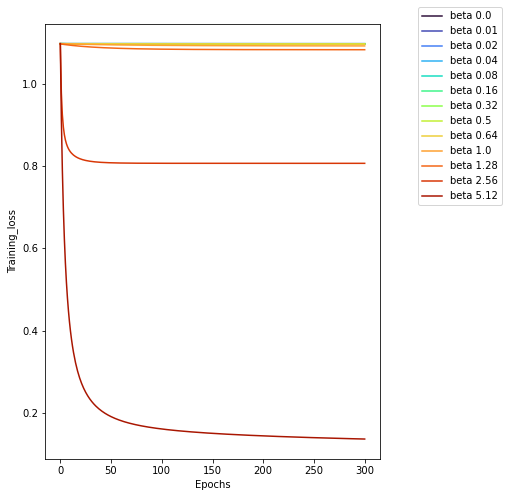

In [59]:
cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(6,8))
for i,j in enumerate(loss_beta):
    plt.plot(j,label ="beta "+str(np.around(beta[i].item(),3)),color = cm(i*20))

plt.xlabel("Epochs")
plt.ylabel("Training_loss")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig("sin_train_loss_4.png",bbox_inches='tight')

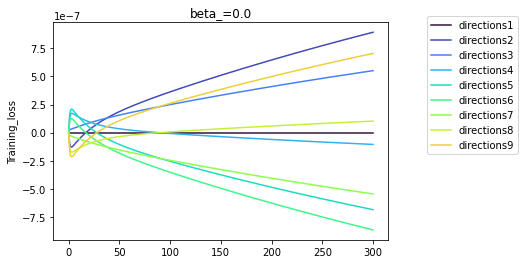

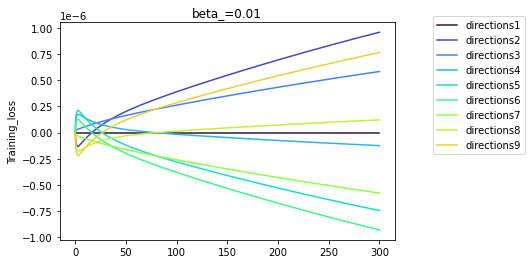

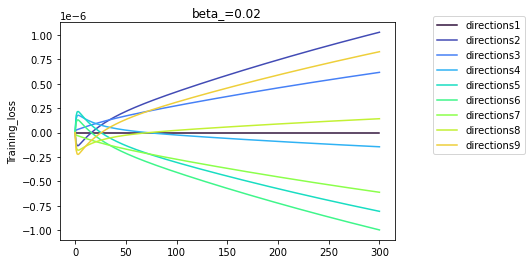

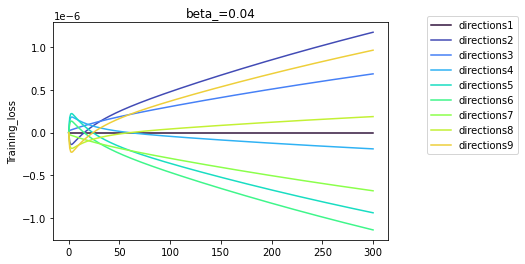

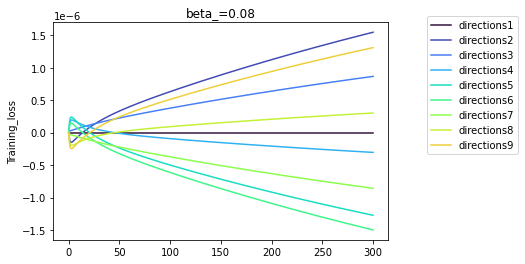

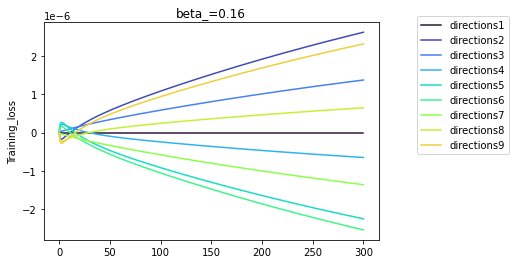

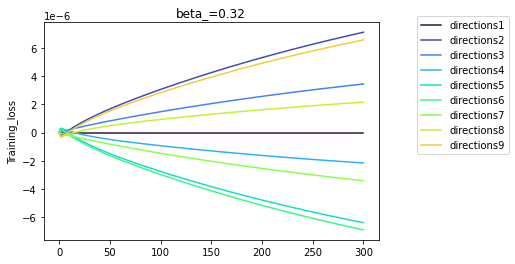

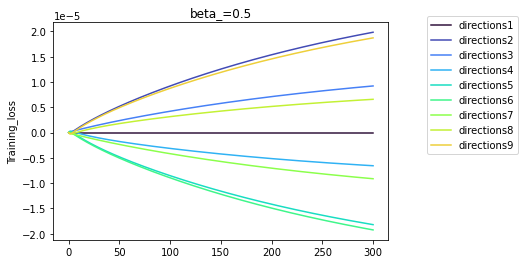

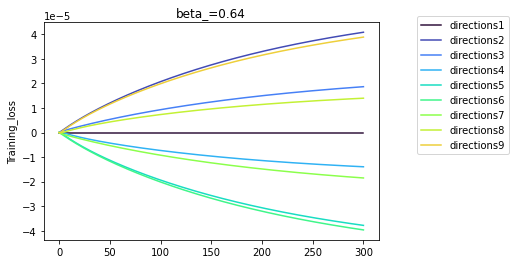

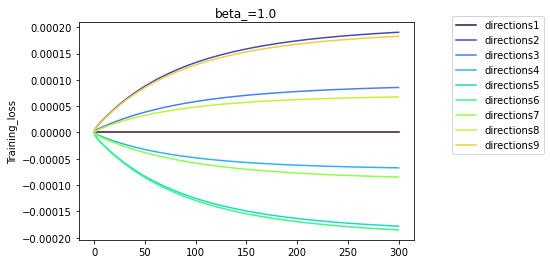

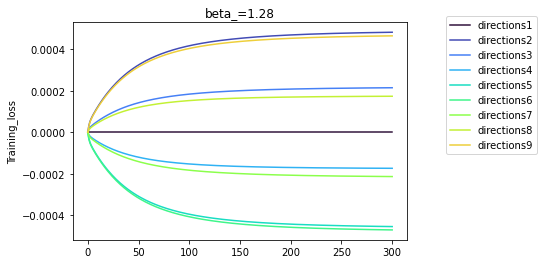

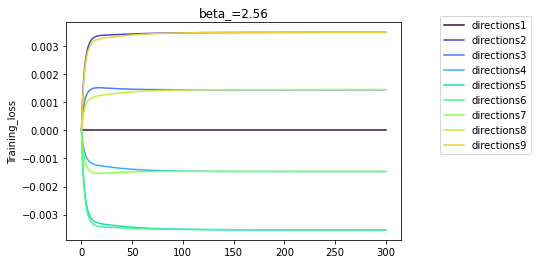

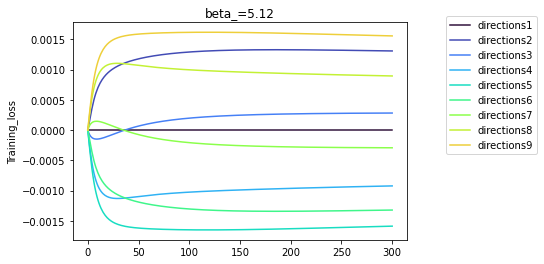

In [60]:
for j in range(len(beta)):
    plt.figure()
    for i in range(len(directions)+1):
        temp = np.array(loss_beta[j]) - test_loss_beta[j][:,i]
        plt.plot(temp,label ="directions"+str(i+1),color = cm(i*20))
        plt.ylabel("Training_loss")
        plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.title("beta_="+str(np.around(beta[j].item(),3)))
        plt.savefig("sin_train_loss_4_loss_beta_"+str(j)+".png",bbox_inches='tight')